## 4. Regression Project: Catch the Extrovert!  ##

### 4.1 The Business Problem ###
**Problem statement:** for the **Community Manager** role, **Mindspace** would like to hire a person with the following characteristics:

**About the role:** https://www.mindspace.me/careers/co/tel-aviv/45.422/community-manager/all
> **Who is the Community Manager?**
You will be responsible for building and maintaining our strong and unique community, you will basically be the heart and soul of our diverse community - *caring, attuned to people’s needs and exceedingly proactive*.

> **Critical competencies for success:**
> * It’s all about the people! Working as a Community Manager means *always being attuned to people’s needs and being customer-centric*.
> * You must be an efficient communicator *who is fearless when it comes to speaking up and making your voice heard* – even in front of those who are superior to you.

**Who is an Extrovert?** https://www.indeed.com/career-advice/career-development/extrovert-traits-career-paths
> An extrovert is someone who thrives in social situations. More than just being outgoing, extroversion means that you gain energy from being around others and find that it lessens when you're alone.

**Proposed solution:** 
* We believe that an Extrovert would be the best fit for the role.
* We will develope a model – based on the MIES online personalty test – to ensure **Mindspace** hires only Extroverts for the role, that is, we will trade off Recall for Precision.

**Method:** 
We will optimize the model for Precision score of more than 0.90 and Recall score of not less than 0.75 by using the F0.5 score for model evaluation


### 4.2 The Data: Multidimensional Introversion-Extraversion Scales (MIES) ###
**Raw data from online personality tests:** https://openpsychometrics.org/_rawdata

> For general public edification the data collected through the personality tests on this website is dumped here. All data is anonymous. Users were informed at the beginning of the test that their answers would be used for research and were asked to confirm that their answers were accurate and suitable for research upon completion (those that did not have been removed from these datasets). 

**MIES test:** https://openpsychometrics.org/tests/MIES
> This is an interactive personality test measuring traits that differ between introverts and extraverts.
The test has 91 statements of opinion that you must rate on a five point scale of how much you agree with each. It should take most people 10-15 minutes to complete.


**Dataset:** https://openpsychometrics.org/_rawdata/MIES_Dev_Data.zip
> The downloadables are .zip files each containing a .csv file with the data and a .txt codebook.

**Description:** 
> Answers to 91 personality items, gender, age, native language, **self reported** introvert-extrovert identity

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import joblib

In [4]:
df = pd.read_csv('data.csv', sep='\t')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7188 entries, 0 to 7187
Columns: 282 entries, Q1A to IE
dtypes: int64(280), object(2)
memory usage: 15.5+ MB


In [6]:
df.head(1)

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,Q4I,Q4E,Q5A,Q5I,Q5E,Q6A,Q6I,Q6E,Q7A,Q7I,Q7E,Q8A,Q8I,Q8E,Q9A,Q9I,Q9E,Q10A,Q10I,Q10E,Q11A,Q11I,Q11E,Q12A,Q12I,Q12E,Q13A,Q13I,Q13E,Q14A,...,Q81E,Q82A,Q82I,Q82E,Q83A,Q83I,Q83E,Q84A,Q84I,Q84E,Q85A,Q85I,Q85E,Q86A,Q86I,Q86E,Q87A,Q87I,Q87E,Q88A,Q88I,Q88E,Q89A,Q89I,Q89E,Q90A,Q90I,Q90E,Q91A,Q91I,Q91E,country,dateload,introelapse,testelapse,surveyelapse,gender,engnat,age,IE
0,5,51,7107,3,91,2522,1,56,6180,2,66,5365,3,74,6646,2,23,2726,3,11,10188,3,15,5676,4,48,5759,5,13,6928,1,63,2703,5,55,2822,3,21,6659,5,...,8118,1,61,2446,3,47,2115,2,68,3423,1,58,2496,4,12,3674,2,60,7304,5,67,883,4,4,11548,3,40,4648,3,35,4609,US,2019-02-20 17:35:52,1,461,16,2,1,23,3


In [7]:
# Convert all column names to lowercase
df.columns = df.columns.str.lower()
df.columns

Index(['q1a', 'q1i', 'q1e', 'q2a', 'q2i', 'q2e', 'q3a', 'q3i', 'q3e', 'q4a',
       ...
       'q91e', 'country', 'dateload', 'introelapse', 'testelapse',
       'surveyelapse', 'gender', 'engnat', 'age', 'ie'],
      dtype='object', length=282)

### 4.3 Target variable distribution ###
**IE variable (raw feature)**

After the main question sequence, the following questions were asked on one final page:

**"Do you identify as either an introvert or extravert?"**

0=No response

1=Introvert 

2=Extravert 

3=No

In [8]:
df.ie.value_counts()

1    4404
3    1769
2     990
0      25
Name: ie, dtype: int64

In [9]:
# Keep records where the target variable value is either 1=Introvert or 2=Extrovert
df = df[(df.ie==1) | (df.ie==2)]

In [10]:
# Replace 1=Introvert values with 0=Introvert
df.ie = df.ie.replace(1, 0)

In [11]:
# Replace 2=Extrovert values with 1=Extrovert
df.ie = df.ie.replace(2, 1)

### IE variable (engineered feature) ###
* **Negative label = 0 = Introvert**
* **Positive label = 1 = Extrovert**

**Note:** The positive label is under-represented in the dataset – about **1:4.5** parts of the negative label

In [12]:
df.ie.value_counts()

0    4404
1     990
Name: ie, dtype: int64

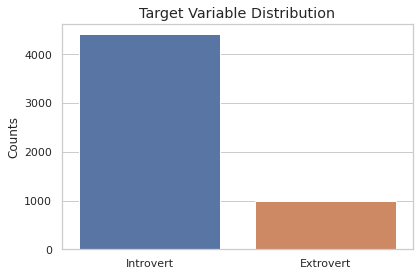

In [13]:
inex = pd.DataFrame(data=df.ie.value_counts(), index={0: 'Introvert', 1: 'Extrovert'})
inex.rename(index={0: 'Introvert', 1: 'Extrovert'}, columns={'ie': 'Counts'}, inplace=True)
sns.set_theme(style='whitegrid', rc={'axes.titlesize': 'large'})
fig, ax = plt.subplots()
ax = sns.barplot(x=inex.index, y=inex.Counts)
ax.set_title('Target Variable Distribution')
fig.tight_layout()

### 4.4 Final page variables ###
After the main question sequence, the following questions were asked on one final page:

**Gender variable**

"What is your gender?"

0=No response

1=Male 

2=Female

3=Other

In [14]:
df.gender.value_counts()

2    3102
1    2078
3     143
0      71
Name: gender, dtype: int64

* We have decided to remove gender categories without a lot of records
* We would like to focus on the Male/Female binary variable and see if it could help us predict the target variable

In [15]:
# Keep records where the gender variable value is either 1 (male) or 2 (female)
df = df[(df.gender==1) | (df.gender==2)]

In [16]:
df.gender.value_counts()

2    3102
1    2078
Name: gender, dtype: int64

In [17]:
# Target variable mean for Males
df[df.gender==1].ie.mean()

0.1693936477382098

In [18]:
# Target variable mean for Females
df[df.gender==2].ie.mean()

0.19310122501611862

* We see that the mean IE value for men is quite similar to that of women, and therefore we conclude that we can exclude the Gender feature from our model

**Engnat variable**

"Is English your native language?"

0=No response

1=Yes

2=No

In [19]:
df.engnat.value_counts()

1    3519
2    1649
0      12
Name: engnat, dtype: int64

In [20]:
df[df.engnat==0].ie.mean()

0.16666666666666666

In [21]:
df[df.engnat==1].ie.mean()

0.19721511793123048

In [22]:
df[df.engnat==2].ie.mean()

0.15463917525773196

* We see a similar mean IE value for all 'engnat' categories, 
and therefore conclude that the 'engnat' variable is insiginifacnt for our model

**Age variable**

"What is your age in years?"

In [23]:
df.age.describe().round()

count    5180.0
mean       28.0
std        62.0
min        14.0
25%        18.0
50%        22.0
75%        30.0
max      2003.0
Name: age, dtype: float64

In [24]:
df.age.sort_values()

6662      14
192       14
3209      14
5358      14
178       14
        ... 
5470    1979
4179    1983
1302    1990
6856    1999
4043    2003
Name: age, Length: 5180, dtype: int64

In [25]:
# Remove 5 records where users misentered their age
df = df[df.age<1000]

In [26]:
df.age.describe().round()

count    5175.0
mean       26.0
std        12.0
min        14.0
25%        18.0
50%        22.0
75%        30.0
max        81.0
Name: age, dtype: float64

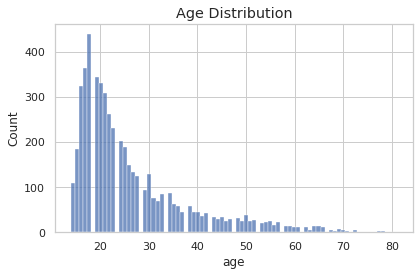

In [27]:
sns.set_theme(style='whitegrid', rc={'axes.titlesize': 'large'})
fig, ax = plt.subplots()
ax = sns.histplot(df.age, bins=81)
ax.set_title('Age Distribution')
fig.tight_layout()

* We assume that age cannot predict In/Extroversion, and will ignore the 'age' variable in our model

The following variables were determined from techincal information:

**country:** user's network location

**dateload:** the time the user loaded the introduction page

**introelapse:** the time spent in seconds on the introduction page

**testelapse:** the time spent in seconds on the test questions

**surveyelapse:** the time spent in seconds on the final page


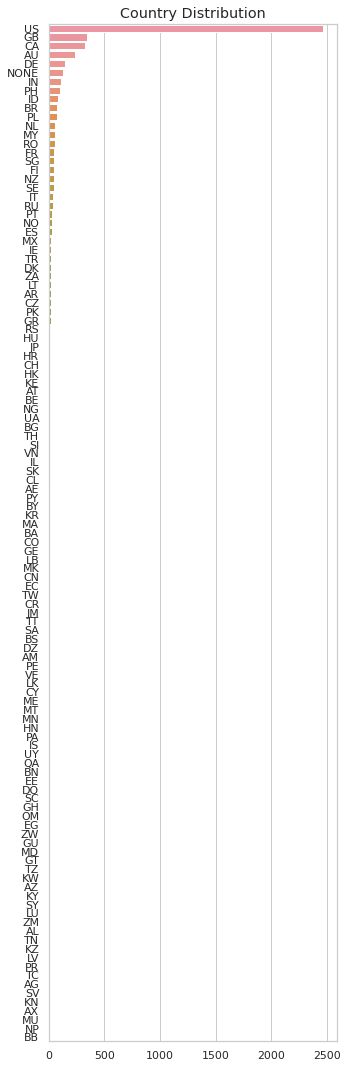

In [28]:
country = df.country.value_counts()
sns.set_theme(style='whitegrid', rc={'axes.titlesize': 'large'})
fig, ax = plt.subplots(figsize=(5, 15))
ax = sns.barplot(x=country.values, y=country.index)
ax.set_title('Country Distribution')
fig.tight_layout()

* We assume that the 5 'technical' variables will not assist us in predicting the IE variable
* However, we will use the 'testelapse' and 'surveyelapse' variables to qualify the dataset

In [29]:
df.testelapse.describe().round(3)

count       5175.000
mean        1242.441
std        19274.442
min          148.000
25%          303.000
50%          379.000
75%          501.000
max      1170335.000
Name: testelapse, dtype: float64

**Testelapse variable:** the time spent in seconds on the test questions
> It should take most people 10-15 minutes to complete.
* Since we would like to exclude persones who lingered over the questions; 
* We are going to remove records where the 'testelapse' value is greater than 15 min (900 sec)

In [30]:
# Keep records where the testelapse value is not greater than 900 sec
df = df[df.testelapse<=900]

In [31]:
df.shape

(4813, 282)

**Surveyelapse variable:** the time spent in seconds on the final page (5 questions in total): gender, age, engnat, IE, and also:
> On the final page, the users were also asked "Do you give accurate answers and can we store and use your data for research?". Only those who answered yes were recorded.

**self reported** introvert-extrovert identity
It should take most people 10-15 minutes to complete.

* Since we would like to exclude persones who lingered over the IE question: "Do you identify as either an introvert or extravert?"	
* And knowing that the mean time spent on each question shouldn't take more than ~10 sec (900 sec divided by 91 questions)
* We are going to remove records where the 'testelapse' value is greater than 50 sec

In [32]:
# Keep records where the surveyelapse value is not greater than 50 sec
df = df[df.surveyelapse<=50]

In [33]:
df.shape

(4526, 282)

In [34]:
df.columns

Index(['q1a', 'q1i', 'q1e', 'q2a', 'q2i', 'q2e', 'q3a', 'q3i', 'q3e', 'q4a',
       ...
       'q91e', 'country', 'dateload', 'introelapse', 'testelapse',
       'surveyelapse', 'gender', 'engnat', 'age', 'ie'],
      dtype='object', length=282)

### 4.5 Data subset ###

**Test questions** (the text of the questions is avialable in the codebook file)

The test contained 91 questions. The questions were presented one at a time in a random order. 
For each questions 3 values were recorded:

> Q1-91**A**: The user's selected response: 1=Disagree, 2=Slightly disagree, 3=Neutral, 4=Slightly agree, 5=Agree

> Q1-91**I**: The position of the question in the survey

> Q1-91**E**: The time elapsed on that question in milliseconds




* We have decided to focus on the user's selected response
* From now on, our data subset will include only 91 features: Q1-91**A**


In [35]:
df.columns

Index(['q1a', 'q1i', 'q1e', 'q2a', 'q2i', 'q2e', 'q3a', 'q3i', 'q3e', 'q4a',
       ...
       'q91e', 'country', 'dateload', 'introelapse', 'testelapse',
       'surveyelapse', 'gender', 'engnat', 'age', 'ie'],
      dtype='object', length=282)

### Feature matrix:  Q1-91A columns ###

In [36]:
# Select the q1-91a columns
X = df.filter(regex='a$', axis='columns')

In [37]:
X.shape

(4526, 91)

### Target vector:  IE column ###
* **Negative label = 0 = Introvert**
* **Positive label = 1 = Extrovert**

In [38]:
# Select the ie column
y = df.ie

In [39]:
y.shape

(4526,)

In [40]:
y.value_counts()

0    3713
1     813
Name: ie, dtype: int64

**Reminder:** The positive label is under-represented in the dataset – about **1:4.6** parts of the negative label

### Mutual information ###

In [41]:
from sklearn.feature_selection import mutual_info_classif

In [42]:
q = X.columns
mi = mutual_info_classif(X, y).round(4)
mi_data = list(zip(q, mi))
mi_df = pd.DataFrame.from_records(mi_data, columns=['Q', 'MI'])
mi_sorted= mi_df.sort_values(by='MI', ascending=False).set_index('Q')
mi_sorted[:10]

,MI
Q,
q83a,0.1918
q82a,0.1857
q91a,0.1753
q90a,0.1635
q81a,0.1613
q80a,0.1427
q89a,0.1227
q84a,0.1226
q14a,0.1063


### 4.6 Split the data  ###

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Check size of dataframes
X_train.shape, X_test.shape

((3620, 91), (906, 91))

In [46]:
# Check size of arrays
y_train.shape, y_test.shape

((3620,), (906,))

### 4.7 Logistic regression

In [47]:
from sklearn.linear_model import LogisticRegression

* ### Fit the model ###

In [48]:
lg = LogisticRegression(solver='liblinear', random_state=42)
lg.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

* ### Train data predictions ###

In [49]:
y_train_predict_lg = lg.predict(X_train)

* ### Classification metrics ###

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

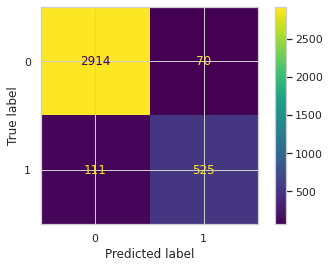

In [51]:
# Display the confusion_matrix
cm = confusion_matrix(y_train, y_train_predict_lg)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lg.classes_)
cmd.plot(values_format='d')

In [52]:
# Unravel the confusion_matrix
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp 

(2914, 70, 111, 525)

**Precision:**

In [53]:
# The precision is the ratio tp / (tp + fp) 
precision = tp / (tp + fp)
precision.round(2)

0.88

**Recall:**

In [54]:
# The recall is the ratio tp / (tp + fn) 
recall = tp / (tp + fn)
recall.round(2)

0.83

**F1 score:** https://en.wikipedia.org/wiki/F-score
> The traditional F-measure or balanced F-score (F1 score) is the harmonic mean of precision and recall: 

In [55]:
f1 = 2 * (precision * recall) / (precision + recall) # pos_label=1
f1.round(2)

0.85

**Classification report:** 

In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_predict_lg))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2984
           1       0.88      0.83      0.85       636

    accuracy                           0.95      3620
   macro avg       0.92      0.90      0.91      3620
weighted avg       0.95      0.95      0.95      3620



**Fβ score:** 
> A more general F score, Fβ, that uses a positive real factor β, where β is chosen such that recall is considered β times as important as precision: 

In [57]:
beta = 1
fbeta = (1 + beta**beta) * (precision * recall) / ((beta**beta * precision) + recall) # pos_label=1
fbeta.round(2)

0.85

In [58]:
from sklearn.metrics import fbeta_score
fbeta = fbeta_score(y_train, y_train_predict_lg, beta=1, average='binary')  # pos_label=1
fbeta.round(2)

0.85

**F2 score:** 
> Two commonly used values for β are 2, which weighs recall higher than precision...

In [59]:
f2 = fbeta_score(y_train, y_train_predict_lg, beta=2, average='binary')  # pos_label=1
f2.round(2)

0.84

**F0.5 score:** 
> ...and 0.5, which weighs recall lower than precision. 

In [60]:
f_half = fbeta_score(y_train, y_train_predict_lg, beta=0.5, average='binary')  # pos_label=1
f_half.round(2)

0.87

**Note:** we will use **F0.5 score** as the evalutaion metric for the models

* ### K-fold cross validation ###

**F0.5 scorer:** make a scorer from the **F0.5 score** metric:

In [61]:
from sklearn.metrics import make_scorer
f_half_scorer = make_scorer(fbeta_score, beta=0.5)
f_half_scorer

make_scorer(fbeta_score, beta=0.5)

**5-fold** cross validation: evaluate model performance using the  **F0.5 score** metric:

In [62]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lg, X_train, y_train, cv=5, scoring=f_half_scorer)
scores

array([0.87114338, 0.7918552 , 0.83190395, 0.81183612, 0.87248322])

In [63]:
print("F0.5 score of %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

F0.5 score of 0.84 with a standard deviation of 0.03


**5-fold** cross validation: evaluate model performance using the following metrics:

* **Precision**
* **Recall**
* **F0.5 score**

**Precision scorer:** make a scorer from the **precision_score** metric:

In [64]:
from sklearn.metrics import precision_score
precision_scorer = make_scorer(precision_score)
precision_scorer

make_scorer(precision_score)

**Recall scorer:** make a scorer from the **recall_score** metric:

In [65]:
from sklearn.metrics import recall_score
recall_scorer = make_scorer(recall_score)
recall_scorer

make_scorer(recall_score)

In [66]:
# Use a dictionary with metric names as keys and callables a values
triple_scoring = {'precision': precision_scorer, 'recall': recall_scorer, 'f_half': f_half_scorer}

In [67]:
from sklearn.model_selection import cross_validate
triple_scores = cross_validate(lg, X_train, y_train, cv=5, scoring=triple_scoring)
triple_scores

{'fit_time': array([0.07465482, 0.07518649, 0.08092308, 0.07353282, 0.08164954]),
 'score_time': array([0.01100159, 0.0111196 , 0.01119399, 0.01099205, 0.01108694]),
 'test_f_half': array([0.87114338, 0.7918552 , 0.83190395, 0.81183612, 0.87248322]),
 'test_precision': array([0.90566038, 0.78358209, 0.85087719, 0.80451128, 0.88888889]),
 'test_recall': array([0.75590551, 0.82677165, 0.76377953, 0.84251969, 0.8125    ])}

In [68]:
precision = triple_scores['test_precision']
recall = triple_scores['test_recall']
f_half = triple_scores['test_f_half']
print("%0.2f Precision score with a standard deviation of %0.2f" % (precision.mean(), precision.std()))
print("%0.2f Recall score with a standard deviation of %0.2f" % (recall.mean(), recall.std()))
print("%0.2f F0.5 score with a standard deviation of %0.2f" % (f_half.mean(), f_half.std()))

0.85 Precision score with a standard deviation of 0.05
0.80 Recall score with a standard deviation of 0.03
0.84 F0.5 score with a standard deviation of 0.03


### 4.8 Logistic regression: regularization ###

* ### Finding the best C parameter ###

In [69]:
for C in [0.001, 0.01, 0.1, 1, 10]:
    lgr = LogisticRegression(solver='liblinear', random_state=42, C=C)
    f_half_scores = cross_val_score(lgr, X_train, y_train, cv=5, scoring=f_half_scorer)
    print('C=%s -> F0.5=%0.2f±%0.2f' % (C, f_half_scores.mean(), f_half_scores.std()))

C=0.001 -> F0.5=0.84±0.01
C=0.01 -> F0.5=0.85±0.02
C=0.1 -> F0.5=0.84±0.03
C=1 -> F0.5=0.84±0.03
C=10 -> F0.5=0.83±0.03


**C=0.01:** we select the C paramter with the best **F0.5 score**

* ### Fit the model ###

In [70]:
# Fit the lgr model with C=0.01
lgr = LogisticRegression(solver='liblinear', random_state=42, C=0.01)
lgr.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=42, solver='liblinear')

* ### Train data probability predictions ###

In [71]:
y_train_predict_proba_lgr = lgr.predict_proba(X_train)[:, -1]

* ### Finding the best threshold ###

In [72]:
from sklearn.metrics import precision_score, recall_score, fbeta_score, roc_auc_score, average_precision_score

thresholds = np.linspace(0, 1, 101)

prec_scores = []
recall_scores = []
f_half_scores = []

for t in thresholds:
    extrovert_predict = (y_train_predict_proba_lgr >= t)
    
    prec = precision_score(y_train, extrovert_predict)
    prec_scores.append(prec)
    
    recall = recall_score(y_train, extrovert_predict)
    recall_scores.append(recall)
    
    f_half = fbeta_score(y_train, extrovert_predict, beta=0.5)
    f_half_scores.append(f_half)
    
    roc_auc = roc_auc_score(y_train, extrovert_predict)
    ap = average_precision_score(y_train, extrovert_predict)
    
    print("%0.2f -> %0.2f | %0.2f | %0.2f | %0.2f | %0.2f" % (t, prec, recall, f_half, roc_auc, ap ))

0.00 -> 0.18 | 1.00 | 0.21 | 0.50 | 0.18
0.01 -> 0.34 | 1.00 | 0.39 | 0.79 | 0.34
0.02 -> 0.41 | 0.99 | 0.46 | 0.84 | 0.41
0.03 -> 0.45 | 0.99 | 0.51 | 0.87 | 0.45
0.04 -> 0.49 | 0.98 | 0.55 | 0.88 | 0.49
0.05 -> 0.53 | 0.98 | 0.58 | 0.90 | 0.52
0.06 -> 0.55 | 0.98 | 0.61 | 0.91 | 0.55
0.07 -> 0.57 | 0.97 | 0.62 | 0.91 | 0.56
0.08 -> 0.60 | 0.97 | 0.65 | 0.92 | 0.59
0.09 -> 0.61 | 0.97 | 0.66 | 0.92 | 0.60
0.10 -> 0.63 | 0.97 | 0.68 | 0.93 | 0.62
0.11 -> 0.64 | 0.96 | 0.69 | 0.92 | 0.63
0.12 -> 0.66 | 0.96 | 0.70 | 0.93 | 0.64
0.13 -> 0.67 | 0.96 | 0.71 | 0.93 | 0.65
0.14 -> 0.68 | 0.96 | 0.72 | 0.93 | 0.66
0.15 -> 0.69 | 0.95 | 0.73 | 0.93 | 0.67
0.16 -> 0.70 | 0.94 | 0.74 | 0.93 | 0.67
0.17 -> 0.71 | 0.94 | 0.75 | 0.93 | 0.68
0.18 -> 0.72 | 0.94 | 0.75 | 0.93 | 0.69
0.19 -> 0.73 | 0.94 | 0.76 | 0.93 | 0.69
0.20 -> 0.74 | 0.93 | 0.77 | 0.93 | 0.70
0.21 -> 0.75 | 0.93 | 0.78 | 0.93 | 0.71
0.22 -> 0.75 | 0.93 | 0.78 | 0.93 | 0.71
0.23 -> 0.76 | 0.93 | 0.79 | 0.93 | 0.72
0.24 -> 0.76 | 0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Threshold=0.59:** we select the threshold with the best **Precision score (=0.91)** for a **Recall score (=0.77)** not lesser than 0.75

* ### Train data predictions ###

In [73]:
y_train_predict_lgr = (y_train_predict_proba_lgr >= 0.59)

**Confusion matrix:** 

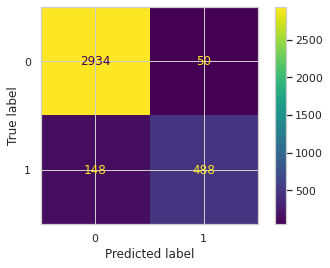

In [74]:
# Display the confusion_matrix
cm = confusion_matrix(y_train, y_train_predict_lgr)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgr.classes_)
cmd.plot(values_format='d')

**Classification report:** 

In [75]:
print(classification_report(y_train, y_train_predict_lgr))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2984
           1       0.91      0.77      0.83       636

    accuracy                           0.95      3620
   macro avg       0.93      0.88      0.90      3620
weighted avg       0.94      0.95      0.94      3620



**F0.5 score** for **lgr** model

In [76]:
f_half_lgr = fbeta_score(y_train, y_train_predict_lgr, beta=0.5, average='binary')  # pos_label=1
f_half_lgr.round(2)

0.88

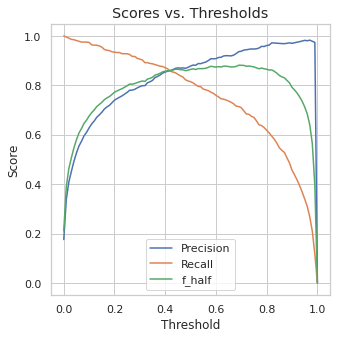

In [77]:
plt.figure(figsize=(5, 5))
plt.plot(thresholds, prec_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f_half_scores, label='f_half')
plt.legend(loc='lower center')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Scores vs. Thresholds')
fig.tight_layout()

* ### Test data probability predictions ###

In [78]:
y_test_predict_proba_lgr = lgr.predict_proba(X_test)[:, -1]

In [79]:
y_test_predict_lgr = (y_test_predict_proba_lgr >= 0.59)

**Confusion matrix: test data predictions** 

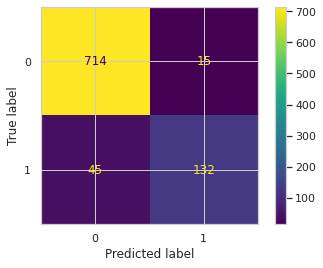

In [80]:
# Display the confusion_matrix
cm = confusion_matrix(y_test, y_test_predict_lgr)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgr.classes_)
cmd.plot(values_format='d')

**Classification report: test data predictions** 

In [81]:
print(classification_report(y_test, y_test_predict_lgr))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       729
           1       0.90      0.75      0.81       177

    accuracy                           0.93       906
   macro avg       0.92      0.86      0.89       906
weighted avg       0.93      0.93      0.93       906



**F0.5 score: test data predictions** 

In [82]:
f_half_lgr_test = fbeta_score(y_test, y_test_predict_lgr, beta=0.5, average='binary')  # pos_label=1
f_half_lgr_test.round(2)

0.86

**Model selection:** we see that lgr model (C=0.01, Treshold=0.59) yielded a precision score of 0.90 and a recall score of 0.75 when applied on the test data. Hence we select this model for the business problem.

### 4.9 Logistic regression: 'balanced' data ###

* To overcome the imbalanced data we will use the class_weight parameter:
> The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data

* ### Fit the model ###

In [83]:
lgb = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
lgb.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

* ### Train data predictions ###

In [84]:
y_train_predict_lgb = lgb.predict(X_train)

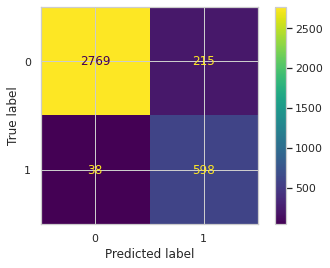

In [85]:
# Display the confusion_matrix
cm = confusion_matrix(y_train, y_train_predict_lgb)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb.classes_)
cmd.plot(values_format='d')

In [86]:
print(classification_report(y_train, y_train_predict_lgb))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2984
           1       0.74      0.94      0.83       636

    accuracy                           0.93      3620
   macro avg       0.86      0.93      0.89      3620
weighted avg       0.94      0.93      0.93      3620



**F0.5 score** for **lgb** model

In [87]:
f_half_lgb = fbeta_score(y_train, y_train_predict_lgb, beta=0.5, average='binary')  # pos_label=1
f_half_lgb.round(2)

0.77

**5-fold** cross validation for **lgb** model

In [88]:
triple_scores = cross_validate(lgb, X_train, y_train, cv=5, scoring=triple_scoring)
triple_scores

{'fit_time': array([0.06693172, 0.09982252, 0.09203744, 0.09607911, 0.0847044 ]),
 'score_time': array([0.01228476, 0.01140213, 0.01147127, 0.01138949, 0.01144457]),
 'test_f_half': array([0.78404402, 0.75096277, 0.75757576, 0.72692794, 0.71341463]),
 'test_precision': array([0.76      , 0.71779141, 0.7278481 , 0.69277108, 0.67630058]),
 'test_recall': array([0.8976378 , 0.92125984, 0.90551181, 0.90551181, 0.9140625 ])}

In [89]:
precision = triple_scores['test_precision']
recall = triple_scores['test_recall']
f_half = triple_scores['test_f_half']
print("%0.2f Precision score with a standard deviation of %0.2f" % (precision.mean(), precision.std()))
print("%0.2f Recall score with a standard deviation of %0.2f" % (recall.mean(), recall.std()))
print("%0.2f F0.5 score with a standard deviation of %0.2f" % (f_half.mean(), f_half.std()))

0.71 Precision score with a standard deviation of 0.03
0.91 Recall score with a standard deviation of 0.01
0.75 F0.5 score with a standard deviation of 0.02


## 4.10 Evaluation metrics ##

* ### ROC curves ###

In [90]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

In [91]:
# Train data probability predictions 
y_train_predict_proba_lg = lg.predict_proba(X_train)[:, -1]
y_train_predict_proba_lgb = lgb.predict_proba(X_train)[:, -1]

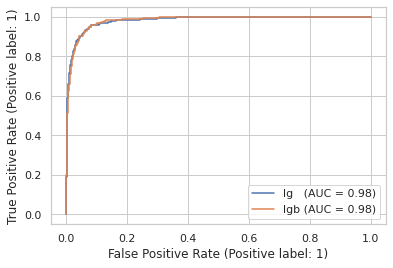

In [92]:
# ROC curves for lg & lgb models
rcd_lg = RocCurveDisplay.from_predictions(y_train, y_train_predict_proba_lg, name='lg  ')
rcd_lgb = RocCurveDisplay.from_predictions(y_train, y_train_predict_proba_lgb, name='lgb', ax=rcd_lg.ax_)

In [93]:
# lg model ROC AUC
roc_auc_score(y_train, y_train_predict_proba_lg).round(4)

0.981

In [94]:
# lgb model ROC AUC
roc_auc_score(y_train, y_train_predict_proba_lgb).round(4)

0.9815

* ### Precision Recall (PR) curves ###

In [95]:
from sklearn.metrics import PrecisionRecallDisplay, auc

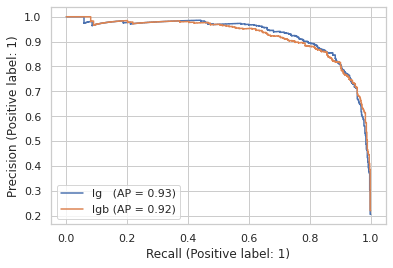

In [96]:
# PR curves for lg & lgb models
prd_lg = PrecisionRecallDisplay.from_predictions(y_train, y_train_predict_proba_lg, name='lg  ')
prd_lgb = PrecisionRecallDisplay.from_predictions(y_train, y_train_predict_proba_lgb, name='lgb', ax=prd_lg.ax_)

In [97]:
# lg model PR AUC
auc(prd_lg.recall, prd_lg.precision).round(3)

0.927

In [98]:
# lgb model PR AUC
auc(prd_lgb.recall, prd_lgb.precision).round(3)

0.923

In [99]:
joblib_file = "LGR.pkl"
joblib.dump(lgr, joblib_file)

['LGR.pkl']

In [100]:
# Load from file
joblib_model = joblib.load(joblib_file)

In [101]:
score = joblib_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))

Test score: 94.04 %
